## Figure 5:

Upper level PV evolution on the 326 K isentrope for the REF simulation from days 5 to 8 (a-d). PV differences between the CRH and REF simulations (CRH-REF) at upper levels on the 326 K isentrope (e-h) and at lower levels on the 925 hPa isobaric surface (i-l). The dynamical tropopause is shown in solid and dashed black lines for CRH and REF simulations respectively. Thin black contours depict the mean surface pressure between the two simulations.

---
@ Behrooz Keshtgar, KIT 2022

## 1- load python packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker
import xarray as xr
import colorlegend
import metpy.calc as mpcalc
import metpy

For reference, print package versions to screen:

In [2]:
print('xarrary:   ', xr.__version__)
print('numpy:     ', np.__version__)
print('metpy:     ', metpy.__version__)
import matplotlib; print('matplotlib:', matplotlib.__version__); del matplotlib

xarrary:    0.16.0
numpy:      1.19.1
metpy:      1.0
matplotlib: 3.3.0


## 2- Loading datasets

In [3]:
# Dictionary for loading simulations
simdict = {
         'LC1-channel-4000x9000km-2km-0002' : {'res':'2km', 'radiation':1, 'rh':0.8}, # No radiation
         'LC1-channel-4000x9000km-2km-0003' : {'res':'2km', 'radiation':1, 'rh':0.8}, # Cloud radiation
             }

In [4]:
# load 3d (temperature and pressure) datasets on model levels
def load_simulations():
    ds_list = []
    for sim in list(simdict.keys()): 
        print('Working on loading data for', sim)
        # loading remapped datasets (0.5x0.5 r)
        path = '/work/bb1135/from_Mistral/bb1135/b381185/output/LC1_Limited_channel/icon-v.2.6.2.2_2km/sim_list_output/'+sim+'_remapped_0.5x0.5/'
        if sim == 'LC1-channel-4000x9000km-2km-0011':
            fname = path+"icon-atm3d*.nc"
        else:    
            fname = path+"icon-fg*.nc"                                                                                  
        ds_var = xr.open_mfdataset(fname)[['temp','pres']]
        ds_list.append(ds_var)
        del ds_var
        
    return ds_list
#----------------------------------
ds_list_fg = load_simulations()

Working on loading data for LC1-channel-4000x9000km-2km-0002
Working on loading data for LC1-channel-4000x9000km-2km-0003


In [5]:
# load atm3d (PV) datasets on model levels
def load_simulations():
    ds_list = []
    for sim in list(simdict.keys()): 
        print('Working on loading data for', sim)
        # loading remapped datasets (0.5x0.5 r)
        path = '/work/bb1135/from_Mistral/bb1135/b381185/output/LC1_Limited_channel/icon-v.2.6.2.2_2km/sim_list_output/'+sim+'_remapped_0.5x0.5/'
        fname = path+"icon-atm3d*.nc"                                                            
        ds_var = xr.open_mfdataset(fname)[['pv']]
        ds_list.append(ds_var)
        del ds_var

    return ds_list
#----------------------------------
ds_list_atm3d = load_simulations()

Working on loading data for LC1-channel-4000x9000km-2km-0002
Working on loading data for LC1-channel-4000x9000km-2km-0003


In [6]:
# load 2d (surface pressure/ isobaric PV) datasets on model levels
def load_simulations():
    ds_list = []
    for sim in list(simdict.keys()): 
        print('Working on loading data for', sim)
        # loading remapped datasets (0.5x0.5 r), interpolated from model height to pressure levels
        path1 = '/work/bb1135/from_Mistral/bb1135/b381185/output/LC1_Limited_channel/icon-v.2.6.2.2_2km/sim_list_output/'+sim+'_remapped_0.5x0.5/datasets_pres/'
        fname1 = path1+"icon-atm3d*.nc"                                                            
        ds_var1 = xr.open_mfdataset(fname1)[['pv']]
        # loading remapped datasets (0.5x0.5 r)
        path2 = '/work/bb1135/from_Mistral/bb1135/b381185/output/LC1_Limited_channel/icon-v.2.6.2.2_2km/sim_list_output/'+sim+'_remapped_0.5x0.5/'
        fname2 = path2+"icon-atm2d*.nc"                                                            
        ds_var2 = xr.open_mfdataset(fname2)[['pres_sfc']]
        
        ds = xr.merge([ds_var1, ds_var2])
        ds_list.append(ds)
        del ds_var1, ds_var2

    return ds_list
#----------------------------------
ds_list = load_simulations()

Working on loading data for LC1-channel-4000x9000km-2km-0002
Working on loading data for LC1-channel-4000x9000km-2km-0003


## 3- Functions

In [7]:
#Gravitation
g=9.80665
#Adiabat-coef (R_L/cp)
kappa=287.04/1004.64
#Reference pressure (Pa)
p00=1e5
#Gas constant
Rd=287.
#lapse rate
alpha=0.0065*Rd/g
#list of isentropes to interpolate (K)
thlevs = np.arange(310,352,2) 

# Potential temperature
def calc_theta(temp, pres):
    return temp * (pres/p00)**(-kappa)

def isentropic(field_ml,theta_ml,thlevs):
    field_thl = np.zeros((len(time), len(thlevs), len(lat), len(lon)), dtype=np.float64)
    for t in range(len(time)):
        for i in range(len(thlevs)):
            field_thl[t,i,:,:] = metpy.interpolate.interpolate_to_isosurface(theta_ml[t,:,:,:]
                                                                       ,field_ml[t,:,:,:],thlevs[i],True)
    return(field_thl)

## 4- Isentropic PV

In [8]:
# common values
lat  = ds_list_fg[0].lat.values
lon  = ds_list_fg[0].lon.values
time = ds_list_fg[0].time

# looping through simulations
for i in range(len(ds_list_atm3d)):
    temp = ds_list_fg[i].temp.values
    pv   = ds_list_atm3d[i].pv.values
    pres = ds_list_fg[i].pres.values

    # Potential temperature 
    theta = calc_theta(temp,pres)
    ipv = isentropic(pv, theta, thlevs)
    # change to data array and add to the dataset
    ds_list_atm3d[i]['ipv'] = xr.DataArray(ipv, dims=('time','lev','lat','lon'),
                                          coords=[time,thlevs,lat,lon])
    
    del temp,pv,pres,theta,ipv

## 5- PV difference at upper and lower levels

In [9]:
# PV error at 326 K
p0 = ds_list_atm3d[0].ipv 
p1 = ds_list_atm3d[1].ipv
pv_diff = p1 - p0        ## CRH simulation - REF simulation

# surface_pressure averaged between the two simulations
p_sfc_mean = (ds_list[0].pres_sfc + ds_list[1].pres_sfc)/2

# PV error at 925 hPa
p0_925 = ds_list[0].pv 
p1_925 = ds_list[1].pv
pv_diff_925 = p1_925 - p0_925        ## CRH simulation - REF simulation

## 6- Plot

<ipython-input-11-94ac277ecf7e>:138: UserWarning: The following kwargs were not used by contour: 'label'
  cs = ax.contour(lon-38,lat,(p0.sel(lev=326,time=20210109)),[2*1e-6],


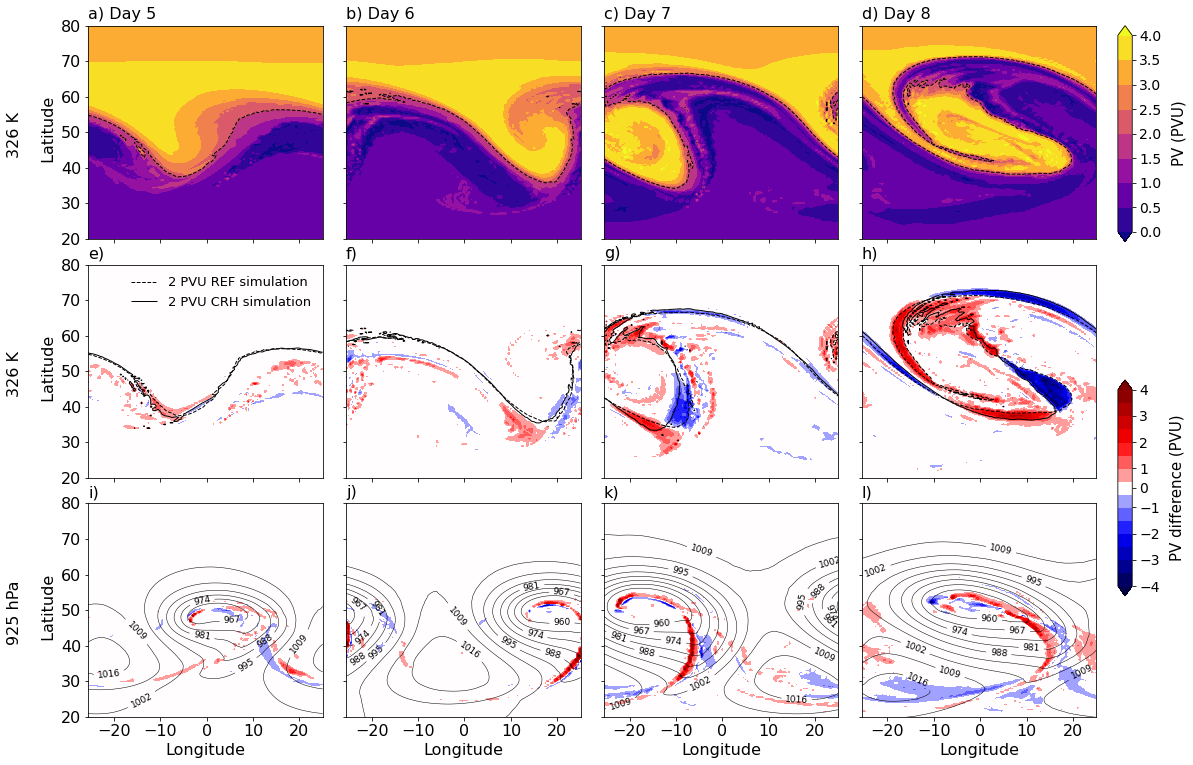

In [11]:
clevels = np.array([-4. , -3.5, -3. , -2.5, -2. , -1.5, -1. , -0.5, 0.5,  1. ,
        1.5,  2. ,  2.5,  3. ,  3.5,  4. ])
#---------------------------------
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 12))

i = 0

for ax in axes.flat:
    
    ax.tick_params(labelsize=16)
    ax.set_ylim([20, 80])
    ax.set_yticks(np.arange(20,90,10))
    ax.set_xticks(np.arange(-20,30,10))
    
    if i == 0:
        
        im0 = ax.contourf(lon-38,lat,(ds_list_atm3d[0].ipv.sel(lev=326,time=20210106))*1e6, 
                     cmap=plt.get_cmap('plasma'),extend='both',levels=np.arange(0.0,4.5,0.5))
        ax.set_xticklabels([]) 
        ax.set_ylabel('326 K \n\n Latitude', fontsize=16)
        
        cs = ax.contour(lon-38,lat,(p0.sel(lev=326,time=20210106)),[2*1e-6],
                        linewidths=1,colors='k',linestyles='dashed')
        
        ax.text(0.0, 1.03, 'a) Day 5', transform=ax.transAxes, 
            size=16)
        
    if i == 1:
        
        im0 = ax.contourf(lon-38,lat,(ds_list_atm3d[0].ipv.sel(lev=326,time=20210107))*1e6, 
                     cmap=plt.get_cmap('plasma'),extend='both',levels=np.arange(0.0,4.5,0.5))
        
        cs = ax.contour(lon-38,lat,(p0.sel(lev=326,time=20210107)),[2*1e-6],
                        linewidths=1,colors='k',linestyles='dashed')
        
        ax.set_xticklabels([]) 
        ax.set_yticklabels([])
        
        ax.text(0.0, 1.03, 'b) Day 6', transform=ax.transAxes, 
            size=16)
        
    if i == 2:
        
        im0 = ax.contourf(lon-38,lat,(ds_list_atm3d[0].ipv.sel(lev=326,time=20210108))*1e6, 
                     cmap=plt.get_cmap('plasma'),extend='both',levels=np.arange(0.0,4.5,0.5))
        
        cs = ax.contour(lon-38,lat,(p0.sel(lev=326,time=20210108)),[2*1e-6],
                        linewidths=1,colors='k',linestyles='dashed')
        
        ax.set_xticklabels([]) 
        ax.set_yticklabels([])
        
        ax.text(0.0, 1.03, 'c) Day 7', transform=ax.transAxes, 
            size=16)
        
    if i == 3:
        
        im0 = ax.contourf(lon-38,lat,(ds_list_atm3d[0].ipv.sel(lev=326,time=20210109))*1e6, 
                     cmap=plt.get_cmap('plasma'),extend='both',levels=np.arange(0.0,4.5,0.5))
        
        cs = ax.contour(lon-38,lat,(p0.sel(lev=326,time=20210109)),[2*1e-6],
                        linewidths=1,colors='k',linestyles='dashed')
        
        ax.set_xticklabels([]) 
        ax.set_yticklabels([])
        
        ax.text(0.0, 1.03, 'd) Day 8', transform=ax.transAxes, 
            size=16)    
    
      
    if i == 4:

        im = ax.contourf(lon-38,lat,(pv_diff.sel(lev=326,time=20210106))*1e6,
                     levels=clevels, 
                     cmap=plt.get_cmap('seismic'),extend='both')

        cs = ax.contour(lon-38,lat,(p0.sel(lev=326,time=20210106)),[2*1e-6],
                        linewidths=1,colors='k',linestyles='dashed')
        
        cs.collections[0].set_label('2 PVU REF simulation')

        cs = ax.contour(lon-38,lat,(p1.sel(lev=326,time=20210106)),[2*1e-6],
                        linewidths=1,colors='k',linestyles='solid')
        
        cs.collections[0].set_label('2 PVU CRH simulation')
        
        ax.legend(loc='upper right',frameon=False,fontsize=13)
        ax.set_xticklabels([]) 
        ax.set_ylabel('326 K \n\n Latitude', fontsize=16)

        ax.text(0.0, 1.03, 'e)', transform=ax.transAxes, 
            size=16)
        
    if i == 5:        

        im = ax.contourf(lon-38,lat,(pv_diff.sel(lev=326,time=20210107))*1e6,
                     levels=clevels, 
                     cmap=plt.get_cmap('seismic'),extend='both')

        cs = ax.contour(lon-38,lat,(p0.sel(lev=326,time=20210107)),[2*1e-6],
                        linewidths=1,colors='k',linestyles='dashed')

        cs = ax.contour(lon-38,lat,(p1.sel(lev=326,time=20210107)),[2*1e-6],
                        linewidths=1,colors='k',linestyles='solid')
        
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        
        ax.text(0.0, 1.03, 'f)', transform=ax.transAxes, 
            size=16)
        
    if i == 6:

        im = ax.contourf(lon-38,lat,(pv_diff.sel(lev=326,time=20210108))*1e6,
                     levels=clevels, 
                     cmap=plt.get_cmap('seismic'),extend='both')

        cs = ax.contour(lon-38,lat,(p0.sel(lev=326,time=20210108)),[2*1e-6],
                        linewidths=1,colors='k',linestyles='dashed')

        cs = ax.contour(lon-38,lat,(p1.sel(lev=326,time=20210108)),[2*1e-6],
                        linewidths=1,colors='k',linestyles='solid')

        ax.set_yticklabels([])
        ax.set_xticklabels([])

        
        ax.text(0.0, 1.03, 'g)', transform=ax.transAxes, 
            size=16)
        
        
    if i == 7:

        im = ax.contourf(lon-38,lat,(pv_diff.sel(lev=326,time=20210109))*1e6,
                     levels=clevels, 
                     cmap=plt.get_cmap('seismic'),extend='both')

        cs = ax.contour(lon-38,lat,(p0.sel(lev=326,time=20210109)),[2*1e-6],
                        linewidths=1,colors='k',linestyles='dashed',label='no-rad')
        
        cs = ax.contour(lon-38,lat,(p1.sel(lev=326,time=20210109)),[2*1e-6],
                        linewidths=1,colors='k',linestyles='solid')

        ax.set_yticklabels([])
        ax.set_xticklabels([])
        
        ax.text(0.0, 1.03, 'h)', transform=ax.transAxes, 
            size=16)       
        
    #------- low level ---------
    if i == 8:

        im = ax.contourf(lon-38,lat,(pv_diff_925.sel(plev_2=92500,time=20210106))*1e6,
                     levels=clevels, 
                     cmap=plt.get_cmap('seismic'),extend='both')

        cf = ax.contour(lon-38,lat,p_sfc_mean.sel(time=20210106)/100,colors='k',linewidths=0.5,
                   levels=np.arange(960,1025,7))
        
        ax.clabel(cf, inline=1, fontsize=9,fmt='%1.f') 

        ax.set_ylabel('925 hPa \n\n Latitude', fontsize=16)
        ax.set_xlabel('Longitude', fontsize=16)
        
        ax.text(0.0, 1.03, 'i)', transform=ax.transAxes, 
            size=16)  
        
    if i == 9:        

        im = ax.contourf(lon-38,lat,(pv_diff_925.sel(plev_2=92500,time=20210107))*1e6,
                     levels=clevels, 
                     cmap=plt.get_cmap('seismic'),extend='both')

        cf = ax.contour(lon-38,lat,p_sfc_mean.sel(time=20210107)/100,colors='k',linewidths=0.5,
                   levels=np.arange(960,1025,7))
        
        ax.clabel(cf, inline=1, fontsize=9,fmt='%1.f')
        
        ax.set_xlabel('Longitude', fontsize=16)
        ax.set_yticklabels([])
        
        ax.text(0.0, 1.03, 'j)', transform=ax.transAxes, 
            size=16)
    
    if i == 10:

        im = ax.contourf(lon-38,lat,(pv_diff_925.sel(plev_2=92500,time=20210108))*1e6,
                     levels=clevels, 
                     cmap=plt.get_cmap('seismic'),extend='both')

        cf = ax.contour(lon-38,lat,p_sfc_mean.sel(time=20210108)/100,colors='k',linewidths=0.5,
                   levels=np.arange(960,1025,7))
        
        ax.clabel(cf, inline=1, fontsize=9,fmt='%1.f')
        
        ax.set_xlabel('Longitude', fontsize=16)
        ax.set_yticklabels([])
        
        ax.text(0.0, 1.03, 'k)', transform=ax.transAxes, 
            size=16)
        
    
    if i == 11:

        im = ax.contourf(lon-38,lat,(pv_diff_925.sel(plev_2=92500,time=20210109))*1e6,
                     levels=clevels, 
                     cmap=plt.get_cmap('seismic'),extend='both')

        cf = ax.contour(lon-38,lat,p_sfc_mean.sel(time=20210109)/100,colors='k',linewidths=0.5,
                   levels=np.arange(960,1025,7))        
        
        ax.clabel(cf, inline=1, fontsize=9,fmt='%1.f')
        
        ax.set_yticklabels([]) 
        ax.set_xlabel('Longitude', fontsize=16)
        
        ax.text(0.0, 1.03, 'l)', transform=ax.transAxes, 
            size=16)
    #---------------------
        
    i = i + 1      

fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8,
                    wspace=0.1, hspace=0.12) 

cb_ax = fig.add_axes([0.815, 0.24, 0.01, 0.25]) # xcenter/ycenter/width/height
cbar = fig.colorbar(im,cax=cb_ax,orientation='vertical',shrink=0.95,ticks=[-4,-3,-2,-1,0,1,2,3,4])
cbar.set_label(label='PV difference (PVU)', size='15',labelpad=10)
cbar.ax.tick_params(labelsize=14)

cb_ax1 = fig.add_axes([0.815, 0.65, 0.01, 0.25]) # xcenter/ycenter/width/height
cbar1 = fig.colorbar(im0,cax=cb_ax1,orientation='vertical',shrink=0.95)
cbar1.set_label(label='PV (PVU)', size='15',labelpad=10)
cbar1.ax.tick_params(labelsize=14)

plt.savefig('figure5.pdf', bbox_inches = 'tight')
#plt.savefig('figure5.png', bbox_inches = 'tight',dpi=100)